# Tweeting Democracy:
### Tweets of the 2020 Democractic Nominee Hopefuls

##### Hanna Born, Thomas Malejko, & Nicole Yoder
##### ANLY 580 (Fall 2020)
##### 8 December 2020

### Prepare the Notebook

In [1]:
## load required packages and set global conditions
import pandas as pd
import numpy as np
from datetime import datetime
import pytz
import re
import nltk
import spacy
import scipy.stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report as clsr
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix
import random
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter 
import pickle

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

np.set_printoptions(suppress=True)

import warnings
warnings.filterwarnings("ignore")

In [2]:
## load spacy
nlp = spacy.load("en_core_web_sm", parser = False)

## load the current list of prefixes & remove # from the list 
## (keep hastags in tact)
prefixes = list(nlp.Defaults.prefixes)
prefixes.remove('#')

## recompile a new prefix regex with the smaller list of prefixes
prefix_regex = spacy.util.compile_prefix_regex(prefixes)
## set the tokenizer prefix_search to use the search of the newly compiled regex
nlp.tokenizer.prefix_search = prefix_regex.search

In [26]:
## set colors for prettier prints
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### Introduction

Since its introduction in 2006, Twitter has evolved into a key platform for modern politics–offering politicians a fast and easy way to communicate their message and priorities to the public. Under the Trump administration, Twitter continued to grow even more central to politics as the President often chose his Twitter account as the preferred medium for connecting with the American people. Twitter’s popularity as a medium for political discourse means that information from political campaigns--everything from campaign events to fundraising to policy platforms--is readily available in real-time. The 2020 Democratic Presidential Primaries were no different. At one point more than two dozen candidates vied for the opportunity represent the Democratic Party in the 2020 Presidential Election. This project examined the tweets made by seven of the most prominent candidates, from the start of August 2019 until Super Tuesday (March 2020), to understand how each candidate used this growing platform to engage prospective voters.

### Literature Review

The rapid expansion of social media over the past decade has challenged the efficacy of existing analytic techniques due to the enormous quantity of data generated by these services (Facebook, Twitter, Youtube, etc.) as well as changes to how people communicate in these online forums. Subsequently, much research has been conducted to understand the feasibility and techniques required to generate useable insights from this data. Four papers, in particular, look at the practicality of conducting topic modelling and authorship detection of tweets. <br><br>
In “Author Identification on Twitter,” Antonio Castro and Brian Lindauer show that an author can be detected with 40 percent accuracy using a regularized linear regression model that relies only on publicly available information on Twitter. Interestingly, the authors comment that tweeters can evade detection by deliberately altering “their writing voice, or limiting the amount of text posted,” which—while beneficial to the political dissenter that the author is concerned about—may complicate our attempt to identify the originating Twitter account since most politicians likely have a multitude of personnel writing their tweet—from public affairs staffs, to aides, to the candidate themselves. Castro and Lindauer’s work builds upon the preeminent research conducted by Arvind Narayanan, et al. in a paper entitled, “On the Feasibility of Internet-Scale Author Identification.” The latter authors showed that neural networks and regularized linear regression models perform equally well for authorship identification, once the data has been normalized, and developed enhanced evaluation metrics including improved confidence estimators. Brunna de Sousa Pereira Amorim, et al. researched classification techniques that could identify tweets that contained political content and, hence, potential electoral crimes in Brazil (for example, out-of-term political advertising is illegal).  As with the previous studies mentioned above, they found that logistic regression models far outperformed neural networks in this task, correctly identifying political tweets with nearly a 90 percent accuracy. Finally, “An Evaluation of Topic Modelling Techniques for Twitter” evaluated multiple techniques for topic modelling on ‘short’ documents, of which Twitter is completely comprised. This paper showed that biterm topic models outperformed—as measured by coherence scores—Latent Dirichlet Allocation (including those modified for use on short texts) and word embedded models such as word2vec.

### The Data

   The dataset being used for this research was collected from 28 May to 9 June 2020 and is comprised of 13,814 tweets from seven of the most prominent 2020 Democratic Presidential Nominee hopefuls, including: Joe Biden, Pete Buttigieg, Tulsi Gabbard, Amy Klobuchar, Bernie Sanders, Tom Steyer, and Elizabeth Warren. The tweets span from 2 August 2019 (approximately the beginning of the 2020 Democratic Primary Campaign) to 2 March 2020 (Super Tuesday), a seven-month period wherein each candidate tweeted at least 1000 times. This dataset was collected via Twitter’s API, reformatted, and saved in a comma separated format that is 5,646 KB in size. In addition to the full text of the tweet, the dataset also contains information about the time, retweet count, and number of times that each tweet was favorited, in addition to, information about the user’s account at the time of the tweet such as follower count and friend count. 

### Prepare the Notebook for Execution

#### Generate Helper Functions

In [3]:
def dataImport(file):
    '''
    Imports the data
    Inputs: file (str)
    Outputs: DF (Pandas DF)
    '''
    #import the dataset
    DF = pd.read_csv(file)
    
    return DF

In [4]:
def summaryStats(DF):
    '''
    Generate Summmary Statitics for the full feature space
    Input: DF (pd DF)
    Output: None
    '''
    
    print('\n###########', 'Summary Statistics', '###########\n')
    print('Dataframe Structure:', DF.shape)

    print('\nVariable Types:')
    print(DF.dtypes)
    
    print('\nSummary Stats (Quantitative Features)')
    print(DF.describe())
    
    print('\nSummary Stats (Qualitative Features)')
    print(DF.describe(include=['object']))

In [5]:
def reformatData(DF):
    '''
    Restructure the data as required (change column names, dtypes, etc) 
    Input: DF (pd DF)
    Output: textDF (pd DF)
    '''
    #rename the columns
    DF.columns = ['Datetime', 'TweetID','FullText', 'Truncated', 'RepliedTo',
                  'GeoTagged', 'Coordinates', 'Location', 'RetweetCount', 
                  'FavoriteCount', 'Sensitive?', 'Lang', 'UserName', 'UserLocation',
                  'UserDescription', 'UserFollowers', 'UserFriends', 'UserStatusCount']
    
    #convert the columns to the appropriate data types
    DF['Datetime']= pd.to_datetime(DF['Datetime']) 
    
    #convert remaining columns to the appropriate type
    DF = DF.astype({'Sensitive?': bool, 'TweetID': str})
    
    #only focused on the text data so only retain columns of interest for
    #textual analysis
    textDF = DF[['Datetime', 'TweetID', 'FullText', 'UserName', 'Lang']]
        
    return textDF

In [6]:
def scoreData(DF):
    '''
    Score the dataframe to ensure that each feature is in the appropriate value range
    and/or has no NA
    Input: DF (pd DF)
    Output: None
    '''
    ##check datetime range
    bad_date = 0
    
    #check date range (June 1, 2019 to Super Tuesday 2020)
    for date in DF['Datetime']:
        if date < datetime(2019, 6, 1, 0, 0, 0, 0, pytz.UTC) or \
            date > datetime(2020, 3, 3, 0, 0, 0, 0, pytz.UTC):
            bad_date += 1
    
    #check for null values
    bad_date += sum(DF['Datetime'].isnull())
    
    #TweetID should be unique
    bad_id = len(DF['TweetID'])-len(DF['TweetID'].drop_duplicates())
    bad_id += sum(DF['TweetID'].isnull())
    
    #FullText cannot be empty
    bad_text = sum(DF['FullText'].isnull()) 
    
    #UserName
    names = ['Amy Klobuchar', 'Bernie Sanders', 'Elizabeth Warren', 'Joe Biden',
             'Pete Buttigieg', 'Tom Steyer', 'Tulsi Gabbard 🌺']
    
    bad_names = 0
    
    for name in DF['UserName']:
        if name not in names:
            bad_names += 1
     
    ## check if the language is not english            
    bad_lang = 0
    
    for language in DF['Lang']:
        if language != 'en':
            bad_lang += 1
    
    ## generate the score
    print('\n######## Data Frame Score by Column #########')   
    print("Date Column: ", bad_date)
    print("TweetID Column: ", bad_id)
    print("Text Column: ", bad_text)
    print("UserNames Column:", bad_names)
    print("Language Column (not English):", bad_lang)
    
    bad_total = bad_date + bad_id + bad_text + bad_names + bad_lang
    score = bad_total / (DF.shape[0]*DF.shape[1])
    
    print('\n######## Total DF Score #########')   
    print('Total DF Cleanliness Score:', 100-round(score * 100, 2))

In [7]:
def cleanData(DF):
    '''
    Clean the dataset by dropping duplicate tweets and removing those that 
    are not in english
    Input: DF (pd DF)
    Output: DF (pd DF)
    '''
    #drop columns with duplicate tweet ID
    DF = DF.drop_duplicates('TweetID', keep = 'last')

    #drop tweets that are not in English    
    DF = DF[DF['Lang'] == 'en']
    
    return DF

In [8]:
def keepChars(tweet):
    '''
    Cleans an invididual tweet by removing non-character features, any url link, 
    etc. Designed to be used with a map function.
    Input: tweet (list of tokens)
    Output: charTweet (list of tokens)
    '''
    ## initialize a list to store the characters only
    charTweet = []
    
    ## do I want to filter NER before I begin?????
    
    for token in tweet:
        ## remove token if it contains a url link
        if 'http' in token.text:
            continue
        
        ## remove a token if it contains a mention, hastag, punctuation, etc.
        elif re.match(r'[^0-9a-zA-Z_]', token.text):
            continue
        
        ## remove token if it is less than one character long
        elif len(token.text) < 2:
            continue
        
        ## append the new token to the character only token list
        else:
            charTweet.append(token)
        
    return charTweet

### Load and Understand the Data

In [9]:
DF = dataImport('Data/DemTweetsReformat.csv')
DF.head(2)

,created_at,id,full_text,truncated,in_reply_to_screen_name,geo,coordinates,place,retweet_count,favorite_count,possibly_sensitive,lang,user.name,user.location,user.description,user.followers_count,user.friends_count,user.statuses_count
0,Mon Mar 02 01:07:24 +0000 2020,1234284135386095616,"John Lewis leading marchers across the Edmund Pettus Bridge in Selma in 1965. What an honor to see him there today, fighting cancer but his voice just as strong. https://t.co/UMp7Snao7T",False,NaN,NaN,NaN,NaN,599,4156,False,en,Amy Klobuchar,NaN,U.S. Senator from Minnesota. Text AMY to 91990 for updates.,1066377,137980,11782
1,Mon Mar 02 00:56:17 +0000 2020,1234281337776955392,Pete Buttigieg has run an inspiring and historic campaign. I have so much respect for you @PeteButtigieg and know there are great things ahead. And both John and I are big fans of Chasten!,False,NaN,NaN,NaN,NaN,5019,89534,NaN,en,Amy Klobuchar,NaN,U.S. Senator from Minnesota. Text AMY to 91990 for updates.,1066377,137980,11782


In [10]:
## get the number of tweets by user
print(DF['user.name'].value_counts())

Elizabeth Warren    2347
Joe Biden           2183
Amy Klobuchar       2017
Tom Steyer          1990
Bernie Sanders      1861
Pete Buttigieg      1700
Tulsi Gabbard 🌺     1085
Name: user.name, dtype: int64


In [12]:
## reformat the dataframe--removing unneeded column
## modifying data types, etc.
DF = reformatData(DF)
## get a preliminary score for the dataset cleanliness
scoreData(DF)


######## Data Frame Score by Column #########
Date Column:  0
TweetID Column:  138
Text Column:  0
UserNames Column: 0
Language Column (not English): 257

######## Total DF Score #########
Total DF Cleanliness Score: 99.4


In [13]:
## clean the data
DF = cleanData(DF)
## rescore the data after edits
scoreData(DF)


######## Data Frame Score by Column #########
Date Column:  0
TweetID Column:  0
Text Column:  0
UserNames Column: 0
Language Column (not English): 0

######## Total DF Score #########
Total DF Cleanliness Score: 100.0


In [14]:
## tokenize every tweet in the dataframe & adding a new column in the process
DF['Tokens'] = DF['FullText'].apply(lambda x: nlp.tokenizer(x))
DF['TextOnly'] = DF['Tokens'].map(keepChars)

In [15]:
##confirm edits and new baseline dataset structure
DF.head()

,Datetime,TweetID,FullText,UserName,Lang,Tokens,TextOnly
0,2020-03-02 01:07:24+00:00,1234284135386095616,"John Lewis leading marchers across the Edmund Pettus Bridge in Selma in 1965. What an honor to see him there today, fighting cancer but his voice just as strong. https://t.co/UMp7Snao7T",Amy Klobuchar,en,"(John, Lewis, leading, marchers, across, the, Edmund, Pettus, Bridge, in, Selma, in, 1965, ., , What, an, honor, to, see, him, there, today, ,, fighting, cancer, but, his, voice, just, as, strong, ., https://t.co/UMp7Snao7, T)","[John, Lewis, leading, marchers, across, the, Edmund, Pettus, Bridge, in, Selma, in, 1965, What, an, honor, to, see, him, there, today, fighting, cancer, but, his, voice, just, as, strong]"
1,2020-03-02 00:56:17+00:00,1234281337776955392,Pete Buttigieg has run an inspiring and historic campaign. I have so much respect for you @PeteButtigieg and know there are great things ahead. And both John and I are big fans of Chasten!,Amy Klobuchar,en,"(Pete, Buttigieg, has, run, an, inspiring, and, historic, campaign, ., , I, have, so, much, respect, for, you, @PeteButtigieg, and, know, there, are, great, things, ahead, ., And, both, John, and, I, are, big, fans, of, Chasten, !)","[Pete, Buttigieg, has, run, an, inspiring, and, historic, campaign, have, so, much, respect, for, you, and, know, there, are, great, things, ahead, And, both, John, and, are, big, fans, of, Chasten]"
2,2020-03-02 00:28:06+00:00,1234274246500720640,"Today, we walked hand-in-hand across the Edmund Pettus Bridge to commemorate the 55th anniversary of #BloodySunday.\n\nThe fight for equal rights continues. We are committed to the simple idea that all men and women are created equal. https://t.co/GuwXuhvIuw",Amy Klobuchar,en,"(Today, ,, we, walked, hand, -, in, -, hand, across, the, Edmund, Pettus, Bridge, to, commemorate, the, 55th, anniversary, of, #BloodySunday, ., \n\n, The, fight, for, equal, rights, continues, ., We, are, committed, to, the, simple, idea, that, all, men, and, women, are, created, equal, ., https://t.co/GuwXuhvIuw)","[Today, we, walked, hand, in, hand, across, the, Edmund, Pettus, Bridge, to, commemorate, the, 55th, anniversary, of, The, fight, for, equal, rights, continues, We, are, committed, to, the, simple, idea, that, all, men, and, women, are, created, equal]"
3,2020-03-01 20:01:05+00:00,1234207050034491392,One way we can make sure kids get a good start is if they have a roof over their head and a stable place to live. We need to guarantee access to affordable housing. I’ll get it done. https://t.co/dLuoWAkkrv,Amy Klobuchar,en,"(One, way, we, can, make, sure, kids, get, a, good, start, is, if, they, have, a, roof, over, their, head, and, a, stable, place, to, live, ., We, need, to, guarantee, access, to, affordable, housing, ., I, ’ll, get, it, done, ., https://t.co/dLuoWAkkrv)","[One, way, we, can, make, sure, kids, get, good, start, is, if, they, have, roof, over, their, head, and, stable, place, to, live, We, need, to, guarantee, access, to, affordable, housing, get, it, done]"
4,2020-03-01 17:30:05+00:00,1234169049573134337,"13 newspapers, from coast to coast and north to south, have endorsed me and our campaign’s optimistic economic agenda. As we travel across the country, we are meeting people where they are, bringing them with us, and building a big coalition to defeat Trump in 2020. https://t.co/fDKJr5dn6T",Amy Klobuchar,en,"(13, newspapers, ,, from, coast, to, coast, and, north, to, south, ,, have, endorsed, me, and, our, campaign, ’s, optimistic, economic, agenda, ., As, we, travel, across, the, country, ,, we, are, meeting, people, where, they, are, ,, bringing, them, with, us, ,, and, building, a, big, coalition, to, defeat, Trump, in, 2020, ., https://t.co/fDKJr5dn6, T)","[13, newspapers, from, coast, to, coast, and, north, to, south, have, endorsed, me, and, our, campaign, optimistic, economic, agenda, As, we, travel, across, the, country, we, are, meeting, people, where, they, are, bringing, th

### Exploratory Data Analysis

### Methodology

#### Research Objectives

Based on the exploratory data analysis, background research, and relevant domain knowledge, the following research objectives were identified. These objectives were thoroughly evaluated using various analytic techniques and machine learning algorithms as to maximize prediction capability or coherence while maximizing the amount of insight about each objective. <br>
   1. Authorship Detection: Predict the author (in this case the Democractic Presidential Nominee Hopeful) given only the text of a previously unseen tweet and understand the stylistic features that most heavily influence the final prediction. <br>
   2. Topic Modeling: Identify the main topics discussed in the candidates’ tweets overall and how the candidates differed in their use of those topics.


#### Part A. Authorship Detection

The process of authorship detection requires a thorough exploratory analysis, above and beyond the techniques used in the previous section, as to understand the stylistic characteristics for each of the seven candidates contained in this dataset. Two 'traditional' approaches were used to accomplish this--the Mendenhall Curve and Kilgariff's Chi-Squared Methods. Combining the results of those analyses with known features of stylistic significance (based on more modern research on this topic), new features were generated from the tweet text. These features were fed into a machine learning pipeline, which tuned the hyperparameters for and evaluatd the efficacy of four distinct models. Once the optimal model was identified, every effort would be made to extract information about the model's selection criterion. 

#### Part B. Topic Modeling
[Topic Modeling notebook](TopicModeling.ipynb)

Two methods of topic modeling, Latent Dirichlet Allocation (LDA) and Non-Negative Matrix Factorization (NMF), were used and evaluated. For both methods, the variable for the number of topics was tested from 5 to 20. Additionally for LDA, the alpha parameter was also tested from the choices of auto, symmetric, and asymmetric. Then the perplexity and topic coherence measures were analyzed to select several possible models. After investigating the top 25 tokens for each of those models to see which model made the most sense to a human, an NMF model with 6 topics was chosen as the best.

### Results

#### Part A. Authorship Detection

##### <em>Mendenhall Curve Method</em>

The analysis below is based on the work of literary scholar T.C. Mendenhall who theorized in 1887 that an author's stylistic signature could be determined by counting how often they used words of different lengths. While coarse by necessity of the time period in which he lived, the results of this analysis can be quickly generated and may provide some interesting insights (François Dominic Laramée, 2018). 

In [16]:
def mendenhallAnalysis(nlp, DF):
    '''
    Generate Mendenhall's Curve to understand the stylometric differences
    between the candidate's tweeting styles
    Input: nlp (spaCy) and DF (pandas)
    Output: None
    '''
    ## initialize a dictionary to store the results
    totalDict = {}
    
    ## for each candidate count the number of times that words of each
    ## word length are used
    for name in DF['UserName'].unique():
        text = DF[DF['UserName'] == name]['TextOnly']
        
        ## the candidate's word length dictionary
        candDict = {}
        
        ## for each tweet calculate the length of each word
        for tweet in text:
            for token in tweet:
                tokenLen = len(token)
                
                ## if that word length exists in the dictionary add one
                ## otherwise add a new value
                if tokenLen in candDict.keys():
                    candDict[tokenLen] += 1
                else:
                    candDict[tokenLen] = 0
        
        ## sum the candidate's total tokens (to generate relative value)
        sumTokens = sum(candDict.values())            
        
        ## generate the relative useage rate and sort by key (word length)
        totalDict[name] = {k: v/sumTokens for k, v in sorted(candDict.items(), key=lambda item: item[0], reverse = False)}
        
    ## generate mendenhall's curve
    fig, ax = plt.subplots(figsize = (12,8))

    for cand in totalDict.keys():
        ## if the candidate's word length range was relatively unique
        ## assign a random color and associate it with their name
        ## otherwise color their curve grey and give the generic 'Other Candidate Label'
        if totalDict[cand][3] > .22:
            ax.plot(totalDict[cand].keys(), totalDict[cand].values(), label = cand)
        elif totalDict[cand][4] < .17:
            ax.plot(totalDict[cand].keys(), totalDict[cand].values(), label = cand)
        else:
            try:
                i
            except:
                i = 0
            ax.plot(totalDict[cand].keys(), totalDict[cand].values(), color = '#D3D3D3',
                    alpha = .6, label = 'Other Candidates' if i == 0 else '')
            i += 1
    
    ## clean the plot and its formatting
    ax.set_xlim(2, 15)    
    ax.set_ylim(0, .24)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Word Length')
    ax.set_ylabel('Percent of Total Words')
    ax.set_yticklabels(["{:.0%}".format(i) for i in ax.get_yticks()])
    ax.set_title("Candidate Word Length Tendancies: Mendenhall's Characteristic Curve", 
                 loc = 'left', fontweight = 'semibold', fontsize = 14)
    ax.legend(title = '$\\bf{Candidate}$', edgecolor = 'none')

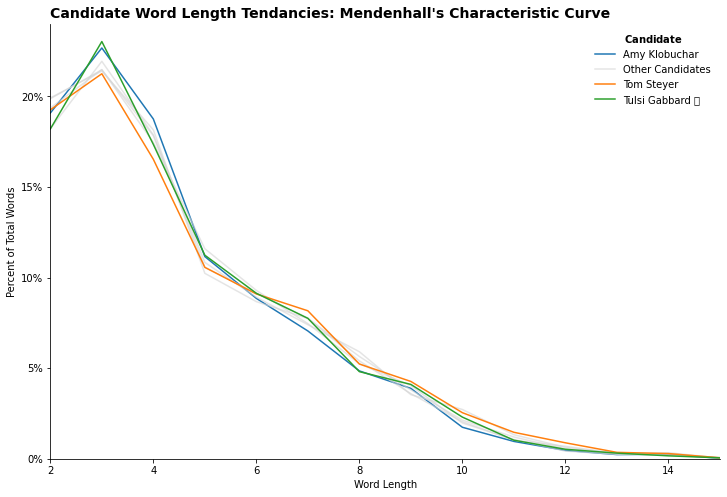

In [17]:
## construct the Mendenhall Curve
mendenhallAnalysis(nlp, DF)

Studying Mendenhall’s Characteristic Curves of Composition, there appears to be little difference in terms of word-length usage between Democratic Presidential Candidates on Twitter. Tom Steyer (the orange curve)--a businessman and non-career politician--had the most distinct curve of the group as he tended to use larger words more frequently than the other canidates. Could this be a sign of his naiveness about what constitutes a successul social media campaign for a politician? Additionally, two of three woman candidates studied (Amy Klobuchar and Tulsi Gabbard) tended to use three-letter words much more frequently than their male-counterparts. This may be a signal a concerted effort by both campaigns to make their candidates appear more relatable by using simple and direct language. 

#### <em> Kilgariff's Chi-Squared Method <em>

Adam Kilgariff, in a 2001 paper, proposed using the chi-squared statistic to determine authorship. According to his method the 'statistic' measurement is a given author's 'distance' from the average use of the most frequent words in the comparison corpus--whether it is a collective corpus, an unknown writing sample, etc. Therefore, the author with a smallest 'statistic' uses the most commonly occuring words at a similar rate to the comparison corpus (François Dominic Laramée, 2018).

<b> Determine the Number of Common Words Shared By All Candidates </b>

Selecting the number of tokens to use in this analysis is non-trivial. Some scholars suggest using between the 100 and 1,000 of the most common types in the corpus, while one researcher even recommended using every word that appeared at least twice. There appears to be some consensus, however, that the number of words selected should be proportional to the corpus size (larger corpus, larger number of common words used in the analysis) as to not give undue importance to infrequent words (François Dominic Laramée, 2018). In an attempt to be more scientific about selecting this critical number of types, a type-frequency diagram was constructed to identify an appropriate number of tokens to be used in this analysis.

In [18]:
def wordCounter(text):
    return Counter([w.lemma_.lower() for w in text])

In [19]:
## instatiate a counter object to store the results
totalCount = Counter()

## get the word count for each type in the corpus 
## and add that to the main counter object
for wDict in DF['Tokens'].map(wordCounter):
    totalCount += wDict

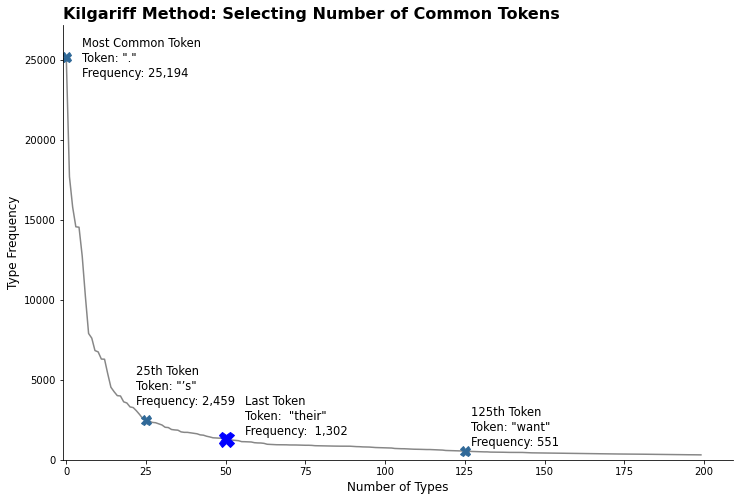

In [23]:
## sort the values and labels accordingly for better plotting
sortedCount = sorted(totalCount.values(), reverse = True)[:200]
sortedLabels = sorted(totalCount, key=totalCount.get, reverse = True) 

## visualize the results
fig, ax = plt.subplots(figsize = (12, 8))    
ax.plot(range(0, 200), sortedCount, color = '#878787')
ax.set_title('Kilgariff Method: Selecting Number of Common Tokens', 
            loc = 'left', fontsize = 16, fontweight = 'demi')

## add the annotation for the cutoff
ax.plot(50, sortedCount[50],
        marker = 'X', markersize = 15, color = 'blue')
text = 'Last Token\nToken:  "{}"\nFrequency:  {:,}'.\
format(sortedLabels[50], sortedCount[50])
ax.annotate(text, xy = (50, sortedCount[50]),
           xytext = (56, sortedCount[50]+250),
           fontsize = 11.5)

## add other annotations for perspective
ax.plot(0, sortedCount[0],
        marker = 'X', markersize = 10, color = '#306998')
text = 'Most Common Token\nToken: "{}"\nFrequency: {:,}'.\
format(sortedLabels[0], sortedCount[0])
ax.annotate(text, xy = (0, sortedCount[0]),
           xytext = (5, sortedCount[0]-1250),
           fontsize = 11.5)

ax.plot(25, sortedCount[25],
        marker = 'X', markersize = 10, color = '#306998')
text = '25th Token\nToken: "{}"\nFrequency: {:,}'.\
format(sortedLabels[25], sortedCount[25])
ax.annotate(text, xy = (25, sortedCount[25]),
           xytext = (22, sortedCount[25]+1000),
           fontsize = 11.5)

ax.plot(125, sortedCount[125],
        marker = 'X', markersize = 10, color = '#306998')
text = '125th Token\nToken: "{}"\nFrequency: {:,}'.\
format(sortedLabels[125], sortedCount[125])
ax.annotate(text, xy = (125, sortedCount[125]),
           xytext = (127, sortedCount[128]+350),
           fontsize = 11.5)

## clean the plot's formatting
ax.set_ylabel('Type Frequency', fontsize = 12)
ax.set_ylim(0,sortedCount[0]+2000)
ax.set_xlabel('Number of Types', fontsize = 12)
ax.set_xlim(-1,)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Given that this corpus is on the smaller size, the number of 'common tokens' should be proportionally small. As such, it is no surprise that this curve appears to level off around 100 types--this value includes types such as '.', 'or', and 'their' but excludes slightly less common words such as 'iowa', 'community', 'want' and 'act.' 

<b> Kilgariff Chi-Squared Method </b>

In [28]:
def kilgariffMethod(DF):
    '''
    Conduct's the Kilgariff Method of authorship analysis by looking
    at how each each author uses the most common words from the corpus
    writ large. The method of calculation relies upon the Chi-Square
    statistic to calculate the author's "distance" from the collective
    mean.
    
    Input: DF (pandas DF)
    Output: chiResults (dictionary)
    '''
    #### get total corpus word count ####
    ## instatiate a counter object to store the results
    totalCount = Counter()

    ## get the word count for each type in the corpus 
    ## and add that to the main counter object
    for wDict in DF['Tokens'].map(wordCounter):
        totalCount += wDict
        
    ## extract the most common 50 words
    totalCommon = totalCount.most_common()[0:50] 
    
    ## store the results of the chi-square test
    chiResults = {}
    
    ## calculate the chi-square value for each candidate's
    ## use of the top 100 words compared to the group norm
    for cand in DF['UserName'].unique():
        ## instatiate a counter for each candidate
        candCount = Counter()
        
        ## generate the word count breakdown for each candidate
        candDict = DF[DF['UserName'] == cand]['Tokens'].map(wordCounter)
        for wDict in candDict:
            candCount += wDict
        
        ##calcuate the canidate's total word count
        candTotal = sum(candCount.values())
        
        ## calculate the chi-square parameters
        actual = []      ## list to store the actual word useage
        expected = []    ## list to store the expected word useage
        
        ## calcuate the canidate's expected useage ratio
        candRatio = candTotal / sum(totalCount.values())
        for word, count in totalCommon:
            actual.append(candCount[word])
            expected.append(candRatio*count)

        ##calculate the chi-square value
        candChi = scipy.stats.chisquare(actual, expected)
        
        ## update the dictionary with each canidate's result
        chiResults[cand] = candChi
        
    return chiResults

In [29]:
## find similarities between tweeters and the whole corpus
chiResults =  kilgariffMethod(DF)

In [30]:
## clean print the results
cleanPrint = pd.DataFrame(chiResults).T
cleanPrint.columns = ['Distance', 'P-Value']
cleanPrint.drop('P-Value', axis = 1, inplace = True)
cleanPrint.sort_values('Distance', axis = 0, ascending = False)

,Distance
Elizabeth Warren,2735.180148
Bernie Sanders,2644.500605
Amy Klobuchar,1807.093963
Tulsi Gabbard 🌺,1579.565244
Joe Biden,1483.695022
Pete Buttigieg,812.529200
Tom Steyer,723.644876


Based on the results calculated above, stylistically, we can say that Tom Steyer and Pete Buttigieg have writing styles most similar to the collective whole while Elizabeth Warren and Bernie Sanders have writing styles that are very different from the rest of Democratic Presidential Nominee Hopefuls. Note, just because two canidates have a score close to each other does not mean that their writing styles are similiar, rather that their writing styles are equi-distant from the collective group average.

As this technique revealed some clear differences between the candidates's tweeting styles, it may be possible to correctly identify  an author given a sufficient number of tweets. To test this hypothesis, the dataset was broken into training and testing datasets at a 80:20 ratio. Bootstrap samples of various tweet sizes (ranging from 1 to 100) were taken for each candidate from the testing dataset and passed into the Kilgariff Chi-Squared Algorithm. The candidate whose known tweets (from the training set) had a chi-squared statistic closest to zero would be assigned as the likely author. These results were then compared to the actual values and scored using the F1-Score.  The interesting results are below:

In [31]:
## load the previously kilgariff results (details can be seen in
## the authorship detection notebook)
kResults = pickle.load(open('kilgariffResults.pkl', 'rb'))

## calcuate the F1-Score for each tweet-size iteration
## recording this result
fscores = []
for result in kResults.values():
    fscores.append(f1_score(result[0], result[1], average = 'macro'))

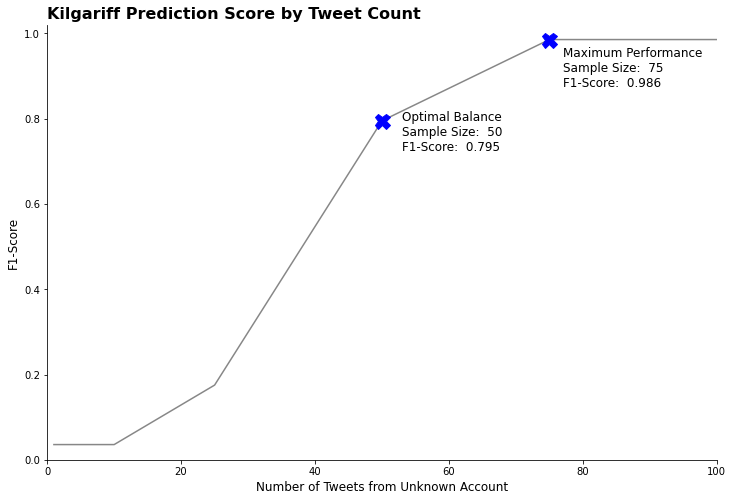

In [32]:
## visualize the results
## create the base plot
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(kResults.keys(), fscores, color = '#878787')
## add an annotation/marker for the optimal value
ax.plot(list(kResults.keys())[4], fscores[4], marker = 'X', 
        markersize = 15, color = 'blue')
text = 'Optimal Balance\nSample Size:  {}\nF1-Score:  {:.3f}'.\
format(str(list(kResults.keys())[4]), fscores[4])
ax.annotate(text, xy = (list(kResults.keys())[4], fscores[4]),
           xytext = (list(kResults.keys())[4]+3, fscores[4]-.07),
           fontsize = 12)
## add an annotation/marker for the maximum performace
ax.plot(list(kResults.keys())[5], fscores[5], marker = 'X', 
        markersize = 15, color = 'blue')
text = 'Maximum Performance\nSample Size:  {}\nF1-Score:  {:.3f}'.\
format(str(list(kResults.keys())[5]), fscores[5])
ax.annotate(text, xy = (list(kResults.keys())[5], fscores[5]),
           xytext = (list(kResults.keys())[5]+2, fscores[5]-.11),
           fontsize = 12)

ax.set_title('Kilgariff Prediction Score by Tweet Count', loc = 'left', 
             fontsize = 16, fontweight = 'demi')
ax.set_xlabel('Number of Tweets from Unknown Account', fontsize = 12)
ax.set_xlim(0, 100)
ax.set_ylabel('F1-Score', fontsize = 12)
ax.set_ylim(0, 1.02)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [33]:
## View Detailed Results for Balanced Results
print(clsr(kResults[50][0], kResults[50][1]))

                  precision    recall  f1-score   support

   Amy Klobuchar       1.00      0.20      0.33        10
  Bernie Sanders       1.00      0.90      0.95        10
Elizabeth Warren       1.00      0.90      0.95        10
       Joe Biden       1.00      0.60      0.75        10
  Pete Buttigieg       1.00      1.00      1.00        10
      Tom Steyer       1.00      1.00      1.00        10
 Tulsi Gabbard 🌺       0.42      1.00      0.59        10

        accuracy                           0.80        70
       macro avg       0.92      0.80      0.80        70
    weighted avg       0.92      0.80      0.80        70



In [34]:
## View Detailed Results for Best Performance
print(clsr(kResults[75][0], kResults[75][1]))

                  precision    recall  f1-score   support

   Amy Klobuchar       1.00      1.00      1.00        10
  Bernie Sanders       1.00      1.00      1.00        10
Elizabeth Warren       1.00      1.00      1.00        10
       Joe Biden       1.00      1.00      1.00        10
  Pete Buttigieg       1.00      0.90      0.95        10
      Tom Steyer       1.00      1.00      1.00        10
 Tulsi Gabbard 🌺       0.91      1.00      0.95        10

        accuracy                           0.99        70
       macro avg       0.99      0.99      0.99        70
    weighted avg       0.99      0.99      0.99        70



This method shows a great deal of promise for authorship detection. Using just 75 tweets, an author could be detected from a field of seven candidates with greater than 99 percent accuracy. With just 50 tweets, the algorithm still runs well achieving nearly 80 percent accuracy. Future analyses should considering rerunning this analysis while also capturing if the correct candidate appeared in the Top X number of candidates.

Specific to this analysis, the model tended to over-attribute tweets to Congresswoman Tulsi Gabbard--something observed in the two cases printed above but was also observed during the construction of the algorithm as well. It seems that her writing style closely matches that of a few other candidates, especially Senator Amy Klobuchar and Vice President Joe Biden.  

#### Part B. Topic Modeling
The selected NMF model had six topics, which were generalized as follows:
1. Campaigning 
    - focused on early voting states like 'Iowa' and 'New Hampshire', asking people to 'join', and highlighting events like 'town halls'.
2. Donations 
    - focused on fundraising with words like 'help', 'chip (in)', 'grassroots', 'donor', and 'donation'.
3. Health Care and Climate Change 
    - mostly focused on 'health care', but 'climate change' is also present.
4. Defeating Donald Trump 
    - this topic has some overlap with the third, since it has 'climate' and 'crisis', but tweets in this category would be focused on how President Trump mishandled the crisis in their view.
5. Workers' Rights and Education 
    - mostly focused on workers' rights with words like 'worker', 'union', and 'pay', but the less common words of 'student', 'school', and 'teacher' extends this topic to education.
6. Gun Violence and Legislation 
    - mostly focused on gun violence with words like 'gun', 'violence', and 'epidemic', but the less common words of 'pass', 'law', 'house', and 'senate' extends this topic to general legislation.

![Wordclouds for Each Topic](Graphics/TopicModeling3.png "Wordclouds for Each Topic")

<b>Results for All Candidates</b>

The Campaigning and Donations topics accounted for about 41% of the tweets, which shows that the candidates frequently used Twitter to advertise their events and fundraise. But the other 59% of tweets were more about policies they would enact or disagree with, which is somewhat surprising based on the short character length available in a tweet.

The Gun Violence and Legislation topic had an unexpected number of tweets, which was caused by two factors. The first was the conversation driven by the mass shootings in El Paso, Dayton, and elsewhere in 2019. The second was the inclusion of many general political/legislative phrases in the topic, which would result in legislative tweets unrelated to gun violence also being categorized in this topic.

![Distribution of Tweets by Topic](Graphics/TopicModeling1.png "Distribution of Tweets by Topic")

<b> Results for Each Candidate </b>

Here are some insights:
- Warren was the closest candidate to tweeting about each topic the same amount and had proportionally more Donations tweets than the others
- Biden and Steyer had proportionally more Defeating Trump tweets
- Sanders had proportionally more Workers' Rights/Education tweets
- Gabbard and Klobuchar had more Campaigning tweets and less Health Care/Climate Change tweets than the rest of the candidates
- Buttigieg had proportionally more Gun Violence/Legislation tweets

President-Elect Biden's message of the importance of defeating President Trump was not unique among the field of candidates, but he emphasized it the most and made it a key pillar of his campaign. This strategy appears to have worked for him, as he won both the Democratic nomination and the general election.

![Percent of Candidates' Tweets Categorized as each Topic](Graphics/TopicModeling2.png "Percent of Candidates' Tweets Categorized as each Topic")

### Conclusion

Something...